In [1]:
import numpy as np

import torch
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils

## Setup Pk

In [3]:
# # from quijote_scattering.features import simple_pk
# # pk = simple_pk(file_spec="m_128_PCS_z=0")
# pk = np.load('/mnt/home/meickenberg/projects/sbi-scattering/notebooks/cache/simple_pk__shape_None__kmax_None__mass_assignment_scheme_PCS__exclude_zero_frequency_True__cap_at_nyquist_True__file_spec_m_128_PCS_z=0__dtype_torch.float32.npz')
# pk['latin_hypercube'].shape
# pk_train = pk['latin_hypercube'][train]
# pk_test = pk['latin_hypercube'][test]
# params = pk['latin_hypercube_parameters']


In [ ]:
# ps = []
# for i in range(2000):
#     try: ps.append(np.stack([np.load('/mnt/ceph/users/cmodi/simbig/mesh/N0256/%04d/power_zheng07.%d.npy'%(i, j))[:, 1] for j in range(3)]))
#     except Exception as e: print(e)

In [4]:
pk = np.load('../data/quijote/latin_hypercube/pkmatter.npy')
pk_fid = np.load('../data/quijote/fiducial/pkmatter.npy')[..., 1]
params = np.load('../data/quijote/latin_hypercube/params.npy')
params_fid = np.load('../data/quijote/fiducial//params.npy')
ndim = len(params_fid)
#
k, pk = pk[0,:, 0], pk[..., 1]
ik05 = np.where(k>0.5)[0][0]
k = k[:ik05]
pk = pk[:, :ik05]
pk_fid = pk_fid[:, :ik05]



In [5]:
train_size_frac = 0.8
train, test = train_test_split(np.arange(2000)[:, np.newaxis], train_size=train_size_frac, random_state=0)
train = train.ravel()
test = test.ravel()
train.shape, test.shape

pk_train = pk[train]
pk_test = pk[test]
params_test = params[test]
params_train = params[train]

ifidp = np.linalg.norm(1 -  params_test/params_fid, axis=1).argmin()
print(ifidp)
params_test[ifidp], params_fid

108


(array([0.3323 , 0.04449, 0.6975 , 0.9715 , 0.8873 ]),
 array([0.3175, 0.049 , 0.6711, 0.9624, 0.834 ]))

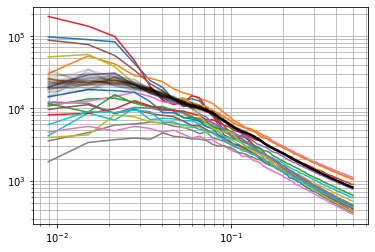

In [6]:

plt.plot(k, pk[::100].T);
plt.plot(k, pk_fid[::100].T , 'k', alpha=0.1);
plt.loglog()
plt.grid(which='both')

### Setup bound

In [7]:
lower_bound, upper_bound = .1 * np.round(10 * params.min(0)) * 0.75, .1 * np.round(10 * params.max(0)) * 1.25
# lower_bound, upper_bound = .1 * np.round(10 * params.min(0)), .1 * np.round(10 * params.max(0))
# lower_bound, upper_bound =  np.round(0.1 * params.min(0)), np.round(10 * params.max(0))

In [8]:
lower_bound, upper_bound = (torch.from_numpy(lower_bound.astype('float32')), 
                            torch.from_numpy(upper_bound.astype('float32')))

In [9]:
lower_bound, upper_bound, params_fid

(tensor([0.0750, 0.0000, 0.3750, 0.6000, 0.4500]),
 tensor([0.6250, 0.1250, 1.1250, 1.5000, 1.2500]),
 array([0.3175, 0.049 , 0.6711, 0.9624, 0.834 ]))

In [10]:
prior = utils.BoxUniform(lower_bound, upper_bound)

## Inference for Pk

In [11]:
log_transform_pk = True

if log_transform_pk:
    pk_train = np.log10(pk_train)
    pk_test = np.log10(pk_test)
    pk_fid = np.log10(pk_fid)
    log_transform_pk = False

In [12]:
standardize_pk = True

if standardize_pk:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    pk_train = scaler.fit_transform(pk_train)
    pk_test = scaler.transform(pk_test)
    pk_fid = scaler.transform(pk_fid)
    standardize_pk = False

In [13]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=50, num_transforms=10)
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(pk_train.astype('float32')))

In [14]:
density_estimator = inference.train(show_train_summary=True)
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 156 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 156
        Best validation performance: 14.7927
        -------------------------
        


In [15]:
cosmonames = r'$\Omega_m$,$\Omega_b$,$h$,$n_s$,$\sigma_8$'.split(",")

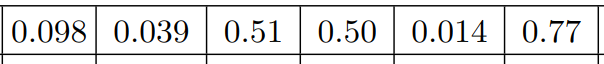

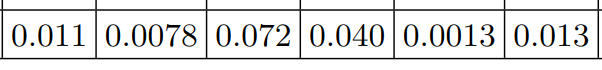

293


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.3175 0.049  0.6711 0.9624 0.834 ]
0
1
2
3
4
[0.02579485 0.00824434 0.07844224 0.06662862 0.00189753]


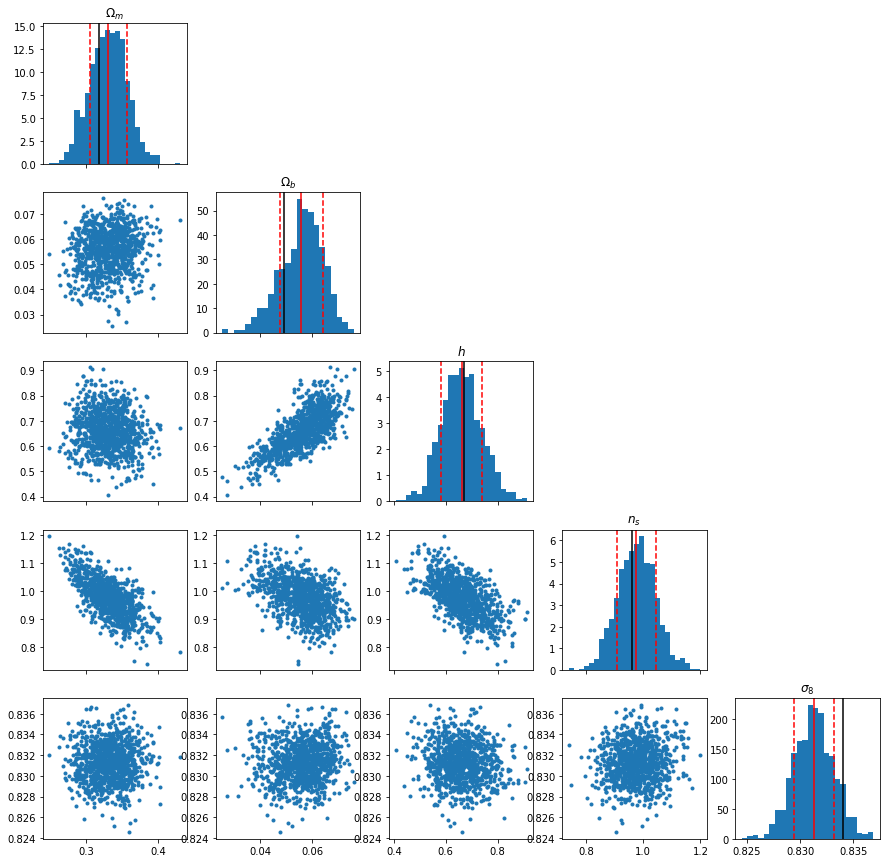

In [16]:
ii = np.random.randint(0, pk_test.shape[0], 1)[0]
# ii = 187
print(ii)
# posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_test[ii].astype('float32')))
# p = params_test[ii]
posterior_samples = posterior.sample((1000,), x=torch.from_numpy(pk_fid[ii].astype('float32'))).detach().numpy()
p = params_fid

print(p)

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
nbins = 'auto'
for i in range(ndim):
    print(i)
    import sys
    sys.stdout.flush()
    axar[i, i].hist(np.array(posterior_samples[:, i]), density=True, bins=nbins);
    axar[i, i].axvline(posterior_samples[:, i].mean(), color='r');
    axar[i, i].axvline(posterior_samples[:, i].mean()+posterior_samples[:, i].std(), color='r', ls="--");
    axar[i, i].axvline(posterior_samples[:, i].mean()-posterior_samples[:, i].std(), color='r', ls="--");
    axar[i, i].axvline(p[i], color='k')
#     axar[i, i].axvline(lower_bound[i])
#     axar[i, i].axvline(upper_bound[i])
    for j in range(0, i):
        axar[i, j].plot(posterior_samples[:, j], posterior_samples[:, i], '.')
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])

print(posterior_samples.std(0))

In [17]:
ranks = []

for ii in range(pk_test.shape[0]):
# for ii in range(180, 190):
    if ii%20 == 0: print(ii)
    posterior_samples = posterior.sample((1000,), x=torch.from_numpy(pk_test[ii].astype('float32')), show_progress_bars=False).detach().numpy()
    order = np.argsort(posterior_samples, 0)
    sorted = np.array([posterior_samples[:, i][order[:, i]] for i in range(ndim)])
    tmp = []
    for i in range(5):
        try: tmp.append(np.where(sorted[i] > params_test[ii, i])[0][0])
        except Exception as e: 
            print(e)
            tmp.append(np.NaN)
    if np.isnan(tmp).sum(): continue
    else: ranks.append(tmp)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


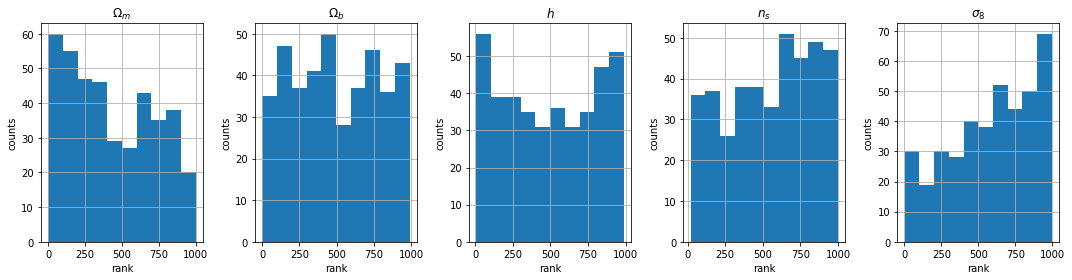

In [18]:
plt.figure(figsize=(15, 4))
for i in range(5):
#     plt.hist(np.array(ranks)[:, i], bins=10, histtype='step', lw=2)
    plt.subplot(151 + i)
    plt.hist(np.array(ranks)[:, i], bins='auto')
    plt.title(cosmonames[i])
    plt.xlabel('rank')
    plt.ylabel('counts')
    plt.grid()
plt.tight_layout()
plt.show()

In [19]:
ranksfid = []

for ii in range(pk_test.shape[0]):
# for ii in range(180, 190):
    if ii%20 == 0: print(ii)
    posterior_samples = posterior.sample((1000,), x=torch.from_numpy(pk_fid[ii].astype('float32')), show_progress_bars=False).detach().numpy()
    order = np.argsort(posterior_samples, 0)
    sorted = np.array([posterior_samples[:, i][order[:, i]] for i in range(ndim)])
    tmp = []
    for i in range(5):
        try: tmp.append(np.where(sorted[i] > params_fid[i])[0][0])
        except Exception as e: 
            print(e)
            tmp.append(np.NaN)
    if np.isnan(tmp).sum(): continue
    else: ranksfid.append(tmp)

0
20
40
60
80
100
120
140
160
180
index 0 is out of bounds for axis 0 with size 0
200
220
240
260
280
300
320
340
360
380
index 0 is out of bounds for axis 0 with size 0


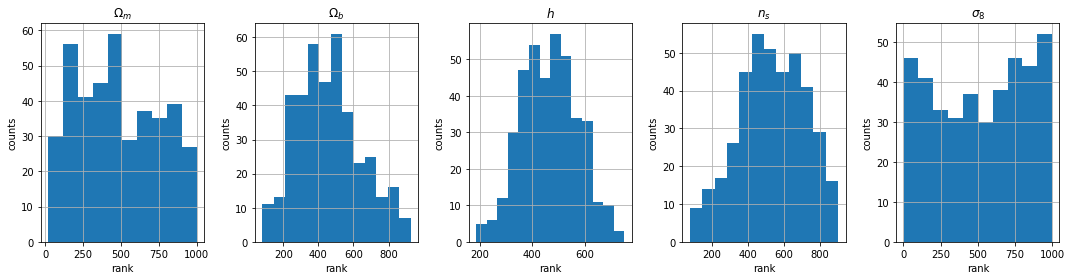

In [20]:
plt.figure(figsize=(15, 4))
for i in range(5):
    plt.subplot(151 + i)
    plt.hist(np.array(ranksfid)[:, i], bins='auto')
    plt.title(cosmonames[i])
    plt.xlabel('rank')
    plt.ylabel('counts')
    plt.grid()
plt.tight_layout()
plt.show()

# Setup Wavelets

In [540]:
# ls /mnt/ceph/users/meickenberg/projects/quijote_harmonic_rings_128 -lisah

In [39]:
# !ls "/mnt/home/meickenberg/ceph/projects/LH_chirag_256/"
# !cat "/mnt/home/meickenberg/ceph/projects/LH_chirag_256/hash_table.dat"

['latin_hypercube',
 'latin_hypercube_parameters',
 'parameter_names',
 'filename',
 'args']

In [170]:
fname = "/mnt/ceph/users/meickenberg/projects/quijote_harmonic_rings_128/f27966395d56e877240abcf86d2f4a3bf7f5bce4.npz"
f = np.load(fname, allow_pickle=True)
f['fiducial'].shape

(8000, 100, 91)

In [ ]:
print(f['args'].item()['integral_powers']) 
np.linalg.norm(w_lh[:, :, 8] - w_lh[:, :, 30]) # integral power 2 sits at index 8 (and also at 30)

In [187]:
# w_lh = f['latin_hypercube']
# w_fid = f['fiducial']
# np.save('../data/quijote/latin_hypercube/wavelets', w_lh)
# np.save('../data/quijote/fiducial//wavelets', w_fid)
# np.save('../data/quijote/latin_hypercube///args_wavelets', f['args'])
w_lh = np.load('../data/quijote/latin_hypercube/wavelets.npy')
w_fid = np.load('../data/quijote/fiducial//wavelets.npy')
args = np.load('../data/quijote/fiducial/args_wavelets.npy', allow_pickle=True)
w_lh.shape, w_fid.shape

((2000, 100, 91), (8000, 100, 91))

In [498]:
# if standardize_wavelets:
#     from sklearn.preprocessing import StandardScaler
#     scaler = StandardScaler()
#     w_lh_reshape = np.log10(w_lh.reshape(w_lh.shape[0], -1))
#     w_train = scaler.fit_transform(w_lh_reshape[train]).reshape(train.size, w_lh.shape[1], w_lh.shape[2])
#     w_test = scaler.transform(w_lh_reshape[test]).reshape(test.size, w_lh.shape[1], w_lh.shape[2])
    
#     w_fid_reshape = np.log10(w_fid.reshape(w_fid.shape[0], -1))
#     w_fid = scaler.transform(w_fid_reshape).reshape(w_fid.shape)

    
def standardize_wavelets(w, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
#         w_reshape = np.log10(w.reshape(w.shape[0], -1))
        w_reshape = (w.reshape(w.shape[0], -1))
        w_train = scaler.fit_transform(w_reshape[train]).reshape(train.size, w.shape[1], w.shape[2])
        w_test = scaler.transform(w_reshape[test]).reshape(test.size, w.shape[1], w.shape[2])
        return w_train, w_test, scaler
    else:
        w_reshape = np.log10(w.reshape(w.shape[0], -1))
        w = scaler.transform(w_reshape).reshape(w.shape)
        return w

# Anaylis with L2 norm

In [499]:
fname = "/mnt/home/meickenberg/ceph/projects/LH_chirag_256/2f40b4a83ba69486b57125e7447683ccf576ecd0.npz"
f = np.load(fname, allow_pickle=True)
list(f.keys())
print(np.allclose(params_test , f['latin_hypercube_parameters'][test]))
w_l0 = f['latin_hypercube']
w_l0_train, w_l0_test, scaler_l0 = standardize_wavelets(w_l0)
print(w_l0_train.shape, w_l0_test.shape)
w_l0q2_train, w_l0q2_test = w_l0_train[..., 8], w_l0_test[..., 8]
print(w_l0q2_train.shape, w_l0q2_test.shape)


True
(1600, 24, 91) (400, 24, 91)
(1600, 24) (400, 24)


/mnt/home/cmodi/miniconda3/envs/ptorch/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1746: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


In [500]:
w_l0.shape, 91*24

((2000, 24, 91), 2184)

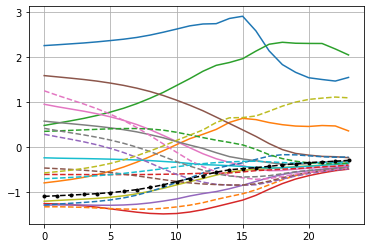

In [501]:
plt.plot(w_l0_train[np.random.randint(0, train.size, 10), :, 8].T, );
plt.plot(w_l0_test[np.random.randint(0, test.size, 10), :, 8].T, '--');
plt.plot(w_l0_train[ifidp, :, 8].T, 'k--', marker='.');
# plt.plot(pk_train[0], marker='.')
# plt.semilogy()
# plt.plot(w_fid[:10, :20, 8].T, 'k', alpha=0.5);
plt.grid(which='both')

In [718]:
# w_l2_train = w_train[:, 4:20, 8] #L=0, skip large scales (noisy?), hence :16. 8==2norm
# w_l2_test = w_test[:, 4:20, 8]


(1600, 16) (400, 16)


In [502]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=50, num_transforms=10)
inference_l0q2 = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference_l0q2.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(w_l0q2_train.astype('float32')))

In [503]:
density_estimator_l0q2 = inference_l0q2.train(show_train_summary=True)
posterior_l0q2 = inference_l0q2.build_posterior(density_estimator_l0q2)

 Neural network successfully converged after 131 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 131
        Best validation performance: 13.5848
        -------------------------
        


296


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

True value : [0.3283  0.05433 0.6657  0.8447  0.9347 ]
Std
tensor([0.0311, 0.0096, 0.0885, 0.0720, 0.0040])
tensor([0.0552, 0.0109, 0.1097, 0.1020, 0.0036])
0
1
2
3


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


4


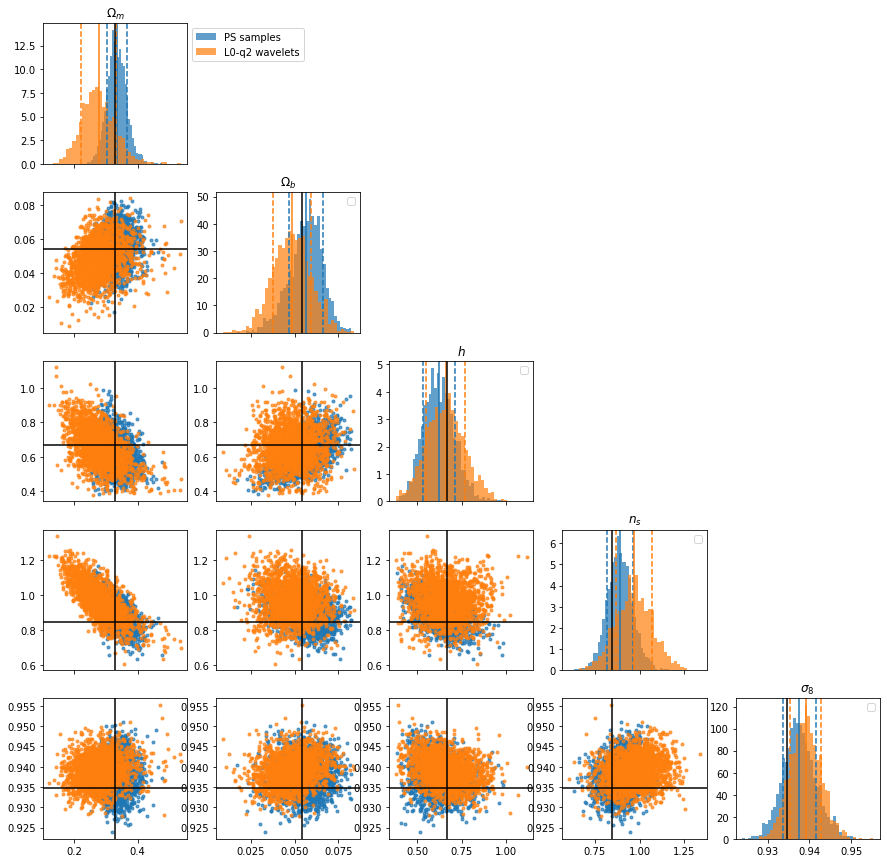

In [504]:
ii = 50
ii = np.random.randint(0, test.size, 1)[0]
print(ii)
posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_test[ii].astype('float32')))
posterior_l0q2_samples = posterior_l0q2.sample((2000,), x=torch.from_numpy(w_l0q2_test[ii].astype('float32')))
print("True value :", params_test[ii])
print("Std")
print(posterior_samples.std(0))
print(posterior_l0q2_samples.std(0))

lbls = ['PS samples', 'L0-q2 wavelets', 'L1+L2 wavelets', 'L1+L2+H wavelets']
# allsamples = [posterior_samples, posterior_l2_samples, posterior_l1l2_samples, posterior_l1l2h1_samples]
allsamples = [posterior_samples, posterior_l0q2_samples]

toplot = [0, 1]
lbls = [lbls[i] for i in toplot]
allsamples = [allsamples[i] for i in toplot]


fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
    print(i)
           
    for iss, samples in enumerate(allsamples):        
        cc ='C%d'%iss
        if i == 0: lbl = lbls[iss]
        else: lbl = None
        axar[i, i].hist(np.array(samples[:, i]), density=True, bins=40, label=lbl, color=cc, alpha=0.7);
        axar[i, i].axvline(samples[:, i].mean(), color=cc);
        axar[i, i].axvline(samples[:, i].mean()+samples[:, i].std(), color=cc, ls="--");
        axar[i, i].axvline(samples[:, i].mean()-samples[:, i].std(), color=cc, ls="--");

        for j in range(0, i):
            axar[i, j].plot(samples[:, j], samples[:, i], '.', color=cc, alpha=0.7)

    
    for j in range(0, i):
        axar[i, j].axhline(params_test[ii][i], color='k')
        axar[i, j].axvline(params_test[ii][j], color='k')

    axar[i, i].axvline(params_test[ii][i], color='k')
    
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])
    axar[i, i].legend(bbox_to_anchor=(1, 1))
    

# L1 + L2 for analysis

In [507]:
# w_l1l2_train = w_train[:, :20, [6, 8]].reshape(train.size, -1) #w_l1l2[train]
# w_l1l2_test =  w_test[:, :20, [6, 8]].reshape(test.size, -1)
w_l0q1q2_train, w_l0q1q2_test = w_l0_train[..., [6, 8]].reshape(train.size, -1), w_l0_test[..., [6, 8]].reshape(test.size, -1)

In [508]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=50, num_transforms=10)

inference_l0q1q2 = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference_l0q1q2.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(w_l0q1q2_train.astype('float32')))

In [509]:
density_estimator_l0q1q2 = inference_l0q1q2.train(show_train_summary=True)
posterior_l0q1q2 = inference_l0q1q2.build_posterior(density_estimator_l0q1q2)

 Neural network successfully converged after 150 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 150
        Best validation performance: 15.1209
        -------------------------
        


136


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]


True values for simulation 136 :  [0.1003  0.05287 0.6379  1.0985  0.8123 ] 

PS samples tensor([0.0100, 0.0067, 0.0917, 0.0457, 0.0086])
L0q2 wavelets tensor([0.0143, 0.0061, 0.1028, 0.1038, 0.0054])
L0q1q2 wavelets tensor([0.0109, 0.0068, 0.1021, 0.0418, 0.0036])


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


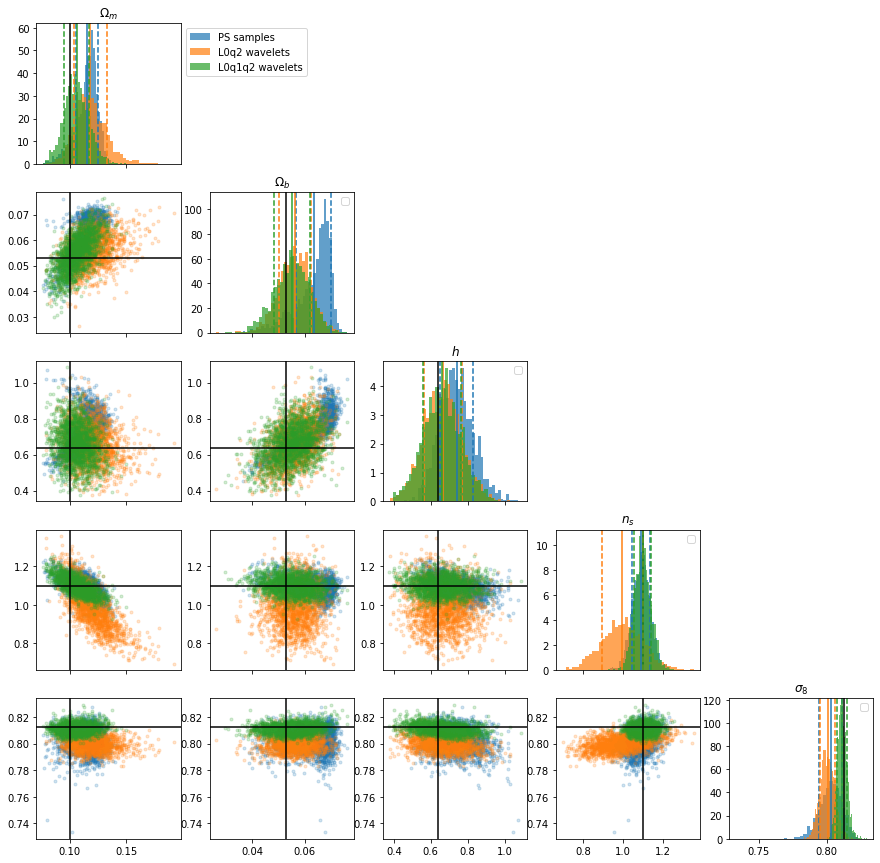

In [510]:
ii = 278
ii = np.random.randint(0, test.size, 1)[0]
print(ii)
posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_test[ii].astype('float32')))
posterior_l0q2_samples = posterior_l0q2.sample((2000,), x=torch.from_numpy(w_l0q2_test[ii].astype('float32')))
posterior_l0q1q2_samples = posterior_l0q1q2.sample((2000,), x=torch.from_numpy(w_l0q1q2_test[ii].astype('float32')))
print( '\nTrue values for simulation %d : '%ii, params_test[ii], '\n')


lbls = ['PS samples', 'L0q2 wavelets', 'L0q1q2 wavelets', 'L0L1q1q2 wavelets']
allsamples = [posterior_samples, posterior_l0q2_samples, posterior_l0q1q2_samples]
for iss, samples in enumerate(allsamples):
    print(lbls[iss], samples.std(0))

#########
toplot = [0, 1, 2]
lbls = [lbls[i] for i in toplot]
allsamples = [allsamples[i] for i in toplot]

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
           
    axar[i, i].axvline(params_test[ii][i], color='k')
    for iss, samples in enumerate(allsamples):        
        cc ='C%d'%iss
        if i == 0: lbl = lbls[iss]
        else: lbl = None
        axar[i, i].hist(np.array(samples[:, i]), density=True, bins=40, label=lbl, color=cc, alpha=0.7);
        axar[i, i].axvline(samples[:, i].mean(), color=cc);
        axar[i, i].axvline(samples[:, i].mean()+samples[:, i].std(), color=cc, ls="--");
        axar[i, i].axvline(samples[:, i].mean()-samples[:, i].std(), color=cc, ls="--");

        for j in range(0, i):
            axar[i, j].plot(samples[:, j], samples[:, i], '.', color=cc, alpha=0.2)

    
    for j in range(0, i):
        axar[i, j].axhline(params_test[ii][i], color='k')
        axar[i, j].axvline(params_test[ii][j], color='k')

    
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])
    axar[i, i].legend(bbox_to_anchor=(1, 1))
    



# for ii, samples in enumerate(allsamples):
#     print(lbls[ii], samples.std(0))


# Next up: Add a higher harmonic order

In [511]:
fname = "/mnt/home/meickenberg/ceph/projects/LH_chirag_256/2247fcf6fe3204901a95b83fa50800d4a0e74a4a.npz"
f1 = np.load(fname, allow_pickle=True)
list(f1.keys())
print(np.allclose(params_test , f1['latin_hypercube_parameters'][test]))
w_l1 = f1['latin_hypercube']
w_l1_train, w_l1_test, scaler_l1 = standardize_wavelets(w_l1)
print(w_l1_train.shape, w_l1_test.shape)


True
(1600, 24, 91) (400, 24, 91)


/mnt/home/cmodi/miniconda3/envs/ptorch/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1746: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


In [512]:
w_l0l1q1q2_train = np.concatenate([w_l0_train[..., [6, 8]], w_l1_train[..., [6, 8]]], axis=2).reshape(train.size, -1)
w_l0l1q1q2_test = np.concatenate([w_l0_test[..., [6, 8]], w_l1_test[..., [6, 8]]], axis=2).reshape(test.size, -1)
# w_l0l1q1q2_train = np.concatenate([w_l0_train[:, :20, [6, 8]], w_l1_train[:, :20, [6, 8]]], axis=2).reshape(train.size, -1)
# w_l0l1q1q2_test = np.concatenate([w_l0_test[:, :20, [6, 8]], w_l1_test[:, :20, [6, 8]]], axis=2).reshape(test.size, -1)
# w_l0l1q1q2_train = np.concatenate([w_l0_train[:, 4:, [6, 8]], w_l1_train[:, 4:, [6, 8]]], axis=2).reshape(train.size, -1)
# w_l0l1q1q2_test = np.concatenate([w_l0_test[:, 4:, [6, 8]], w_l1_test[:, 4:, [6, 8]]], axis=2).reshape(test.size, -1)
print(w_l0l1q1q2_train.shape, w_l0l1q1q2_test.shape)


(1600, 96) (400, 96)


In [471]:
# params_train2 = np.concatenate([params_train, params_train[np.where(params_train[:, 0] > 0.3)[0]]])
# params_train2[:, 0] = params_train2[:, 0] - params_train2[:, 1]  
# w_l0l1q1q2_train2 = np.concatenate([w_l0l1q1q2_train, w_l0l1q1q2_train[np.where(params_train[:, 0] > 0.3)[0]]])
# w_l0l1q1q2_train2.shape

(2399, 96)

In [472]:
# # prior2 
# lower_bound2 = lower_bound*1.
# lower_bound2[0] = 0 
# # prior2 = utils.BoxUniform(lower_bound2[[0, 3, 4]], upper_bound[[0, 3, 4]])
# prior2 = utils.BoxUniform(lower_bound2, upper_bound)

In [513]:
# density_estimator_build_fun = posterior_nn(model='maf', hidden_features=50, num_transforms=10)
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=50, num_bins=32, num_transforms=10)
inference_l0l1q1q2 = SNPE(prior=prior2, density_estimator=density_estimator_build_fun)
inference_l0l1q1q2.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(w_l0l1q1q2_train.astype('float32')))
# inference_l0l1q1q2.append_simulations(
#     torch.from_numpy(params_train2[:,].astype('float32')), 
#     torch.from_numpy(w_l0l1q1q2_train2.astype('float32')))


In [514]:
density_estimator_l0l1q1q2 = inference_l0l1q1q2.train(show_train_summary=True)
posterior_l0l1q1q2 = inference_l0l1q1q2.build_posterior(density_estimator_l0l1q1q2)

 Neural network successfully converged after 191 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 191
        Best validation performance: 15.6560
        -------------------------
        


In [478]:
# ii = np.random.randint(0, test.size, 1)[0]
# posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_test[ii].astype('float32')))
# posterior_l0q2_samples = posterior_l0q2.sample((2000,), x=torch.from_numpy(w_l0q2_test[ii].astype('float32')))
# posterior_l0q1q2_samples = posterior_l0q1q2.sample((2000,), x=torch.from_numpy(w_l0q1q2_test[ii].astype('float32')))
# posterior_l0l1q1q2_samples = posterior_l0l1q1q2.sample((2000,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')))
# ###Correct dims
# posterior_l0l1q1q2_samples = np.hstack([posterior_l0l1q1q2_samples[:, 0:1] , posterior_samples[:, [1, 2]], posterior_l0l1q1q2_samples[:, [1, 2]]])
# print( '\nTrue values for simulation %d : '%ii, params_test[ii], '\n')

# lbls = ['PS samples', 'L0q2 wavelets', 'L0q1q2 wavelets', 'L0L1q1q2 wavelets']
# allsamples = [posterior_samples, posterior_l0q2_samples, posterior_l0q1q2_samples, posterior_l0l1q1q2_samples]
# for iss, samples in enumerate(allsamples):
#     print(lbls[iss], samples.std(0))



Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]


True values for simulation 335 :  [0.2935  0.04131 0.7663  1.0597  0.8149 ] 

PS samples tensor([0.0219, 0.0073, 0.0906, 0.0707, 0.0015])
L0q2 wavelets tensor([0.0626, 0.0109, 0.1051, 0.0947, 0.0019])
L0q1q2 wavelets tensor([0.0383, 0.0105, 0.0976, 0.0564, 0.0012])
L0L1q1q2 wavelets tensor([0.0287, 0.0101, 0.0988, 0.0356, 0.0012])


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


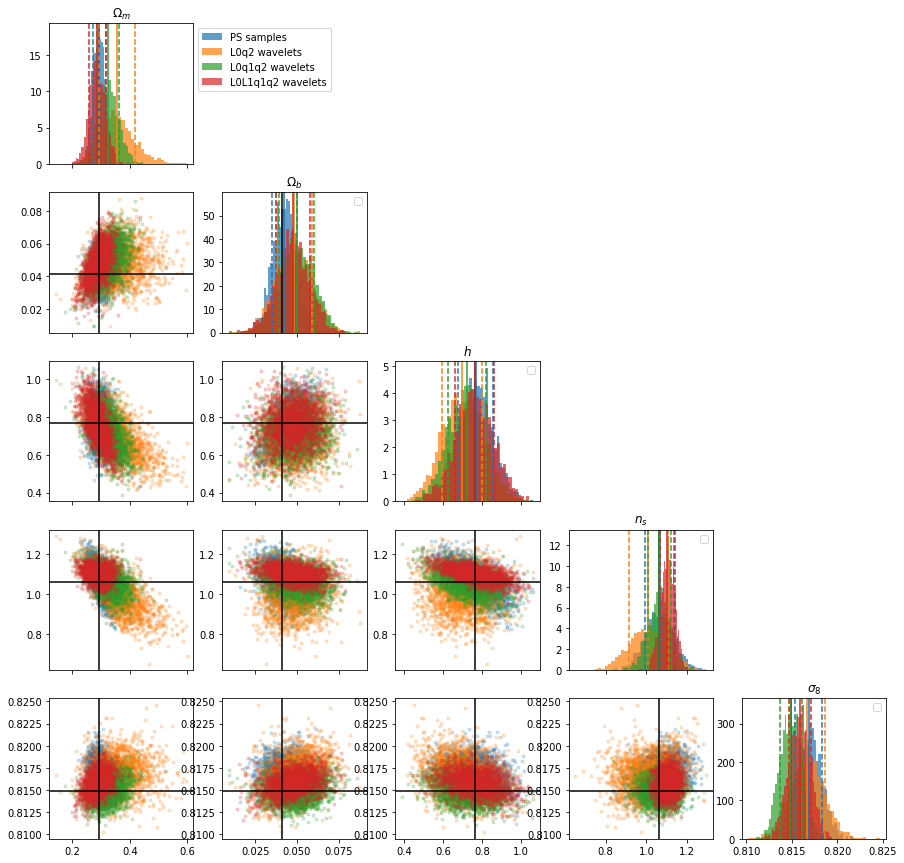

In [515]:
ii = np.random.randint(0, test.size, 1)[0]
posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_test[ii].astype('float32')))
posterior_l0q2_samples = posterior_l0q2.sample((2000,), x=torch.from_numpy(w_l0q2_test[ii].astype('float32')))
posterior_l0q1q2_samples = posterior_l0q1q2.sample((2000,), x=torch.from_numpy(w_l0q1q2_test[ii].astype('float32')))
posterior_l0l1q1q2_samples = posterior_l0l1q1q2.sample((2000,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')))
#Correction
# posterior_l0l1q1q2_samples[:, 0] = posterior_l0l1q1q2_samples[:, 0] + posterior_l0l1q1q2_samples[:, 1]
print( '\nTrue values for simulation %d : '%ii, params_test[ii], '\n')


lbls = ['PS samples', 'L0q2 wavelets', 'L0q1q2 wavelets', 'L0L1q1q2 wavelets']
allsamples = [posterior_samples, posterior_l0q2_samples, posterior_l0q1q2_samples, posterior_l0l1q1q2_samples]
for iss, samples in enumerate(allsamples):
    print(lbls[iss], samples.std(0))

    
###########    
toplot = [0, 1, 2, 3]
lbls = [lbls[i] for i in toplot]
allsamples = [allsamples[i] for i in toplot]

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
           
    axar[i, i].axvline(params_test[ii][i], color='k')
    for iss, samples in enumerate(allsamples):        
        cc ='C%d'%iss
        if i == 0: lbl = lbls[iss]
        else: lbl = None
        axar[i, i].hist(np.array(samples[:, i]), density=True, bins=40, label=lbl, color=cc, alpha=0.7);
        axar[i, i].axvline(samples[:, i].mean(), color=cc);
        axar[i, i].axvline(samples[:, i].mean()+samples[:, i].std(), color=cc, ls="--");
        axar[i, i].axvline(samples[:, i].mean()-samples[:, i].std(), color=cc, ls="--");

        for j in range(0, i):
            axar[i, j].plot(samples[:, j], samples[:, i], '.', color=cc, alpha=0.2)

    
    for j in range(0, i):
        axar[i, j].axhline(params_test[ii][i], color='k')
        axar[i, j].axvline(params_test[ii][j], color='k')

    
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])
    axar[i, i].legend(bbox_to_anchor=(1, 1))


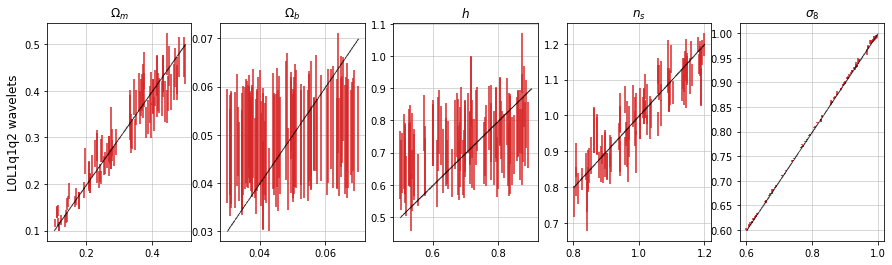

In [517]:
fig, ax = plt.subplots(1, ndim, figsize=(15, 4), sharex='col', sharey='col')

xx = []
nsamples = 1000
for i in range(100):
    
    ii = np.random.randint(0, params_test.shape[0])
    ss = posterior_l0l1q1q2.sample((nsamples,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')), show_progress_bars=False)
#     ss[:, 0] = ss[:, 0] + ss[:, 1]
#     ss2 = posterior.sample((nsamples,), x=torch.from_numpy(pk_test[ii].astype('float32')), show_progress_bars=False)
#     ss = np.hstack([ss[:, 0:1] , ss2[:, [1, 2]], ss[:, [1, 2]]])
    x = params_test[ii]

    xx.append(x)
    for j in range(ndim):
        ax[j].errorbar(x[j], ss[:, j].mean(axis=0), ss[:, j].std(axis=0), color='C%d'%iss)

for j in range(ndim):
    if j == 0 : ax[0].set_ylabel(lbls[iss], fontsize=12)
    ax[ j].plot(params_train[:, j], params_train[:, j], 'k.', ms=0.1, lw=0.5)
    ax[ j].grid(which='both', lw=0.5)
    ax[j].set_title(cosmonames[j], fontsize=12)


In [518]:
scaler_l0.scale_

array([2.05897017e-02, 3.25318251e-02, 5.42668612e-02, ...,
       6.39065749e+05, 8.29701903e+05, 1.07783853e+06])

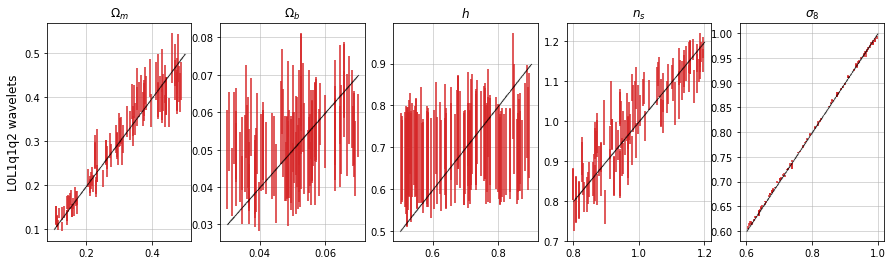

In [397]:
fig, ax = plt.subplots(1, ndim, figsize=(15, 4), sharex='col', sharey='col')

xx = []
nsamples = 1000
for i in range(100):
    
    ii = np.random.randint(0, params_test.shape[0])
    ss = posterior_l0l1q1q2.sample((nsamples,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')), show_progress_bars=False)
    x = params_test[ii]

    xx.append(x)
    for j in range(ndim):
        ax[j].errorbar(x[j], ss[:, j].mean(axis=0), ss[:, j].std(axis=0), color='C%d'%iss)

for j in range(ndim):
    if j == 0 : ax[0].set_ylabel(lbls[iss], fontsize=12)
    ax[ j].plot(params_train[:, j], params_train[:, j], 'k.', ms=0.1, lw=0.5)
    ax[ j].grid(which='both', lw=0.5)
    ax[j].set_title(cosmonames[j], fontsize=12)


In [269]:
# ii = 50
# ii = 120
# posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_test[ii].astype('float32')))
# posterior_l2_samples = posterior_l2.sample((2000,), x=torch.from_numpy(w_l2_test[ii].astype('float32')))
# posterior_l1l2_samples = posterior_l1l2.sample((2000,), x=torch.from_numpy(w_l1l2_test[ii].astype('float32')))
# posterior_l1l2h1_samples = posterior_l1l2h1.sample((2000,), x=torch.from_numpy(w_l1l2h1_test[ii].astype('float32')))
# print("True value :", params_test[ii])
# print("Std")
# print(posterior_samples.std(0))
# # print(posterior_l2_samples.std(0))
# print(posterior_l1l2_samples.std(0))
# # print(posterior_l1l2h1_samples.std(0))

# lbls = ['PS samples', 'L2 wavelets', 'L1+L2 wavelets', 'L1+L2+H wavelets']
# allsamples = [posterior_samples, posterior_l2_samples, posterior_l1l2_samples, posterior_l1l2h1_samples]

# toplot = [0, 2]
# lbls = [lbls[i] for i in toplot]
# allsamples = [allsamples[i] for i in toplot]


# fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
# for i in range(ndim):
#     print(i)
           
#     for iss, samples in enumerate(allsamples):        
#         cc ='C%d'%iss
#         if i == 0: lbl = lbls[iss]
#         else: lbl = None
#         axar[i, i].hist(np.array(samples[:, i]), density=True, bins=40, label=lbl, color=cc, alpha=0.7);
#         axar[i, i].axvline(samples[:, i].mean(), color=cc);
#         axar[i, i].axvline(samples[:, i].mean()+samples[:, i].std(), color=cc, ls="--");
#         axar[i, i].axvline(samples[:, i].mean()-samples[:, i].std(), color=cc, ls="--");

#         for j in range(0, i):
#             axar[i, j].plot(samples[:, j], samples[:, i], '.', color=cc, alpha=0.7)

    
#     for j in range(0, i):
#         axar[i, j].axhline(params_test[ii][i], color='k')
#         axar[i, j].axvline(params_test[ii][j], color='k')

#     axar[i, i].axvline(params_test[ii][i], color='k')
    
#     for j in range(i+1, ndim):
#         axar[i, j].set_axis_off()
# for i in range(ndim): 
#     axar[i, i].set_title(cosmonames[i])
#     axar[i, i].legend(bbox_to_anchor=(1, 1))
    



# Tests

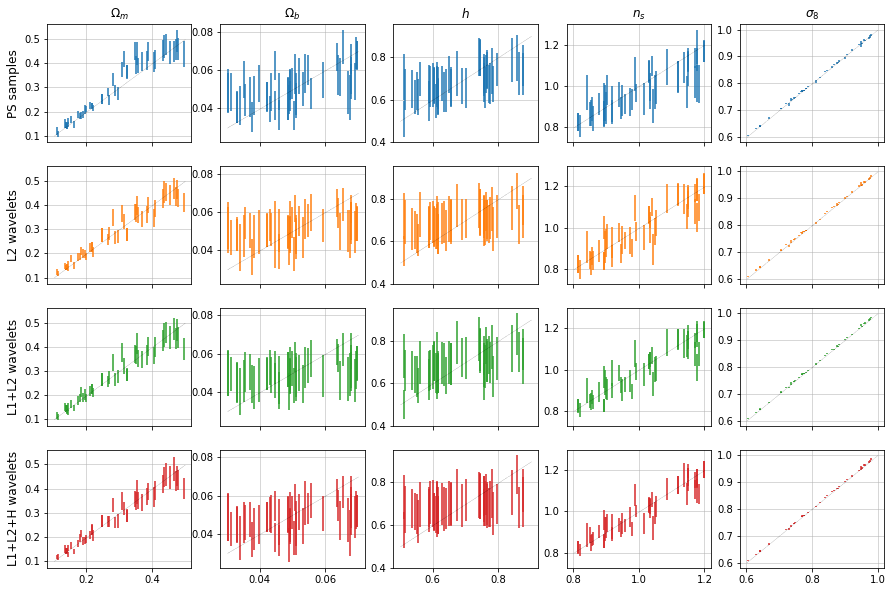

In [289]:
fig, ax = plt.subplots(4, ndim, figsize=(15, 10), sharex='col', sharey='col')

xx = []
lbls = ['PS samples', 'L2 wavelets', 'L1+L2 wavelets', 'L1+L2+H wavelets']
nsamples = 1000
for i in range(50):
    ii = np.random.randint(0, params_test.shape[0])
    spk = posterior.sample((nsamples,), x=torch.from_numpy(pk_train[ii].astype('float32')), show_progress_bars=False)
    sl0q2 = posterior_l0q2.sample((nsamples,), x=torch.from_numpy(w_l0q2_train[ii].astype('float32')), show_progress_bars=False)
    sl0q1q2 = posterior_l0q1q2.sample((nsamples,), x=torch.from_numpy(w_l0q1q2_train[ii].astype('float32')), show_progress_bars=False)
    sl0l1q1q2 = posterior_l0l1q1q2.sample((nsamples,), x=torch.from_numpy(w_l0l1q1q2_train[ii].astype('float32')), show_progress_bars=False)
    x = params_train[ii]

    allsamples = [spk, sl0q2, sl0q1q2, sl0l1q1q2]
    xx.append(x)
    for j in range(ndim):
        for iss in range(4):
            ax[iss, j].errorbar(x[j], allsamples[iss][:, j].mean(axis=0), allsamples[iss][:, j].std(axis=0), color='C%d'%iss)

for j in range(ndim):
    for iss in range(4):
        if j == 0 : ax[iss, 0].set_ylabel(lbls[iss], fontsize=12)
        ax[iss, j].plot(params_train[:, j], params_train[:, j], 'k.', ms=0.01, lw=0.5)
        ax[iss, j].grid(which='both', lw=0.5)
    ax[0, j].set_title(cosmonames[j], fontsize=12)

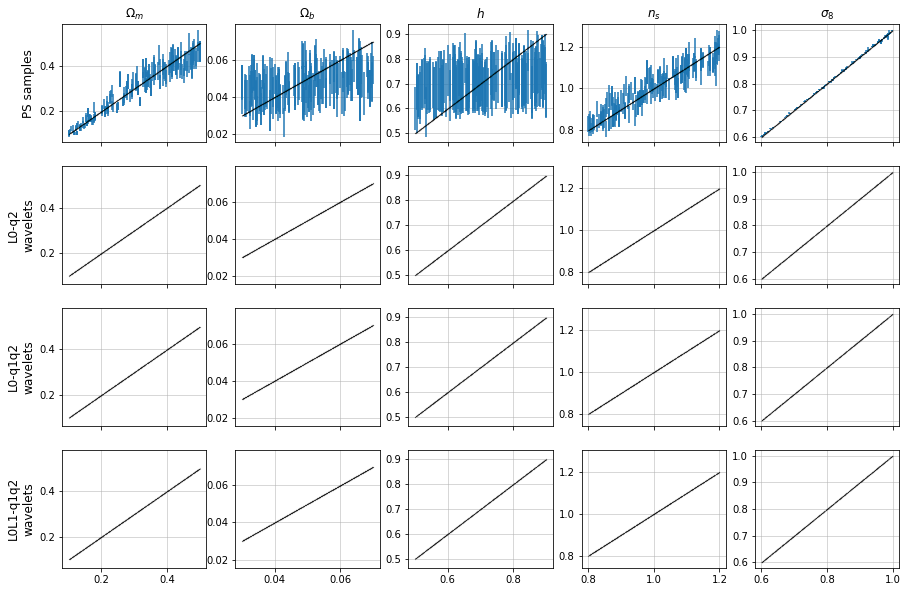

In [297]:
fig, ax = plt.subplots(4, ndim, figsize=(15, 10), sharex='col', sharey='col')

xx = []
nsamples = 1000
for i in range(200):
    
    ii = np.random.randint(0, params_test.shape[0])
#     spk = posterior.sample((nsamples,), x=torch.from_numpy(pk_test[ii].astype('float32')), show_progress_bars=False)
#     sl0q2 = posterior_l0q2.sample((nsamples,), x=torch.from_numpy(w_l0q2_test[ii].astype('float32')), show_progress_bars=False)
#     sl0q1q2 = posterior_l0q1q2.sample((nsamples,), x=torch.from_numpy(w_l0q1q2_test[ii].astype('float32')), show_progress_bars=False)
    sl0l1q1q2 = posterior_l0l1q1q2.sample((nsamples,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')), show_progress_bars=False)
    x = params_test[ii]

#     allsamples = [spk, sl0q2, sl0q1q2, sl0l1q1q2]
    allsamples = [sl0l1q1q2]
    xx.append(x)
    for j in range(ndim):
        for iss in range(len(allsamples)):
            ax[iss, j].errorbar(x[j], allsamples[iss][:, j].mean(axis=0), allsamples[iss][:, j].std(axis=0), color='C%d'%iss)

for j in range(ndim):
    for iss in range(4):
        if j == 0 : ax[iss, 0].set_ylabel(lbls[iss], fontsize=12)
        ax[iss, j].plot(params_train[:, j], params_train[:, j], 'k.', ms=0.1, lw=0.5)
        ax[iss, j].grid(which='both', lw=0.5)
    ax[0, j].set_title(cosmonames[j], fontsize=12)


(array([0.01364103, 0.0909402 , 0.24099154, 0.37285483, 0.36830782,
        0.30919669, 0.2228035 , 0.12731628, 0.06365814, 0.00909402]),
 array([-2.5309064 , -1.9810946 , -1.4312828 , -0.8814709 , -0.33165908,
         0.21815276,  0.7679646 ,  1.3177764 ,  1.8675883 ,  2.4174001 ,
         2.967212  ], dtype=float32),
 <BarContainer object of 10 artists>)

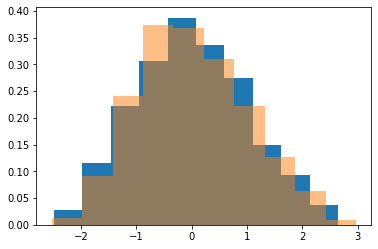

In [193]:
ii, jj = np.random.randint(0, 96, 2)
# plt.hist(pk_train[:, ii], density=True)
# plt.hist(pk_test[:, ii], density=True, alpha=0.5)
# plt.hist(pk['latin_hypercube'][:, ii], density=True)
# plt.hist(np.log(pk['latin_hypercube'])[:, ii], density=True)
# plt.hist(pk_test[:, ii], density=True, alpha=0.5)
plt.hist(w_l0l1q1q2_train[:, ii], density=True)
plt.hist(w_l0l1q1q2_test[:, ii], density=True, alpha=0.5)

# Train simple NN

In [208]:
from torch import nn
import torch.optim as optim


# define model architecture
model = nn.Sequential(
    nn.Linear(pk_train.shape[-1], 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.Sigmoid(),
    nn.Linear(16, 5),
)
print(model)


Sequential(
  (0): Linear(in_features=79, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=16, out_features=5, bias=True)
)


In [209]:
inp = torch.tensor(pk_train[0:10], dtype=torch.float32)
output = model(inp)
criterion = nn.MSELoss()
target = torch.tensor(params_train[0:10], dtype=torch.float32)  # a dummy target, for example
# target = target.view(1, -1)  # make it the same shape as output

loss = criterion(output, target)
print(loss)

tensor(0.5952, grad_fn=<MseLossBackward0>)


[]

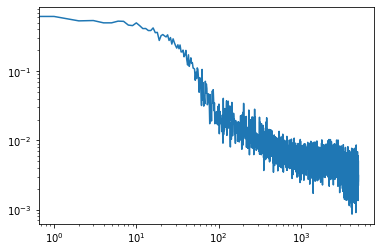

In [210]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# in your training loop:
batch = 8 
losses = []
for j in range(5000):
    optimizer.zero_grad()   # zero the gradient buffers
    idx = np.random.randint(0, train.size, batch)
    inp = torch.tensor(pk_train[idx], dtype=torch.float32)
    target = torch.tensor(params_train[idx], dtype=torch.float32)  # a dummy target, for example
    output = model(inp)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()    # Does the update
    losses.append(loss.detach().numpy())

plt.plot(losses)
plt.loglog()

In [211]:
nnpred_train = model(torch.tensor(pk_train, dtype=torch.float32)).detach().numpy()
nnpred = model(torch.tensor(pk_test, dtype=torch.float32)).detach().numpy()


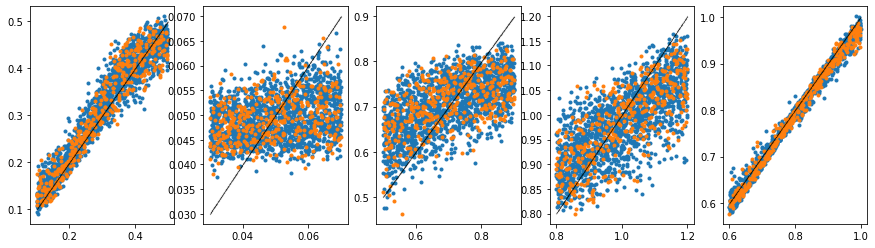

In [212]:
fig, ax = plt.subplots(1, ndim, figsize=(15, 4), sharex='col', sharey='col')

for i in range(ndim):
    ax[i].plot(params_train[:, i], nnpred_train[:, i], 'C0.')
    ax[i].plot(params_test[:, i], nnpred[:, i], 'C1.')
    ax[i].plot(params_train[:, i], params_train[:, i], 'k.', ms=0.1, lw=0.5)


# Repeat for wavelets

In [320]:
# define model architecture
model_wl0l1q1q2 = nn.Sequential(
    nn.Linear(w_l0l1q1q2_test.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.Sigmoid(),
    nn.Linear(16, 5),
)

criterion = nn.MSELoss()


[]

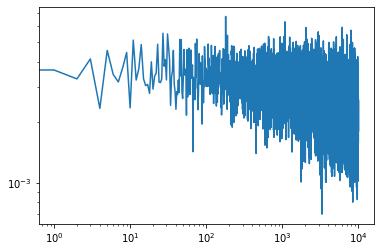

In [325]:

# create your optimizer
optimizer = optim.Adam(model_wl0l1q1q2.parameters(), lr=0.001)

# in your training loop:
batch = 16
losses = []
for j in range(10000):
    optimizer.zero_grad()   # zero the gradient buffers
    idx = np.random.randint(0, train.size, batch)
    inp = torch.tensor(w_l0l1q1q2_train[idx], dtype=torch.float32)
    target = torch.tensor(params_train[idx], dtype=torch.float32)  # a dummy target, for example
    output = model_wl0l1q1q2(inp)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()    # Does the update
    losses.append(loss.detach().numpy())

plt.plot(losses)
plt.loglog()

In [326]:
nnpred = model(torch.tensor(pk_test, dtype=torch.float32)).detach().numpy()
nnpred_wl0l1q1q2 = model_wl0l1q1q2(torch.tensor(w_l0l1q1q2_test, dtype=torch.float32)).detach().numpy()
nnpred_wl0l1q1q2_train = model_wl0l1q1q2(torch.tensor(w_l0l1q1q2_train, dtype=torch.float32)).detach().numpy()


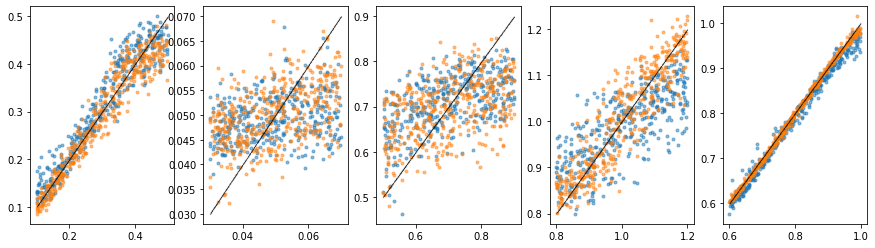

In [331]:
fig, ax = plt.subplots(1, ndim, figsize=(15, 4), sharex='col', sharey='col')

for i in range(ndim):
#     ax[i].plot(params_train[:, i], nnpred_train[:, i], 'C0.', alpha=0.5)
#     ax[i].plot(params_train[:, i], nnpred_wl1l2h1_train[:, i], 'C1.', alpha=0.5)
    ax[i].plot(params_test[:, i], nnpred[:, i], 'C0.', alpha=0.5)
    ax[i].plot(params_test[:, i], nnpred_wl0l1q1q2[:, i], 'C1.', alpha=0.5)
    ax[i].plot(params_train[:, i], params_train[:, i], 'k.', ms=0.1, lw=0.5)


# Compare all

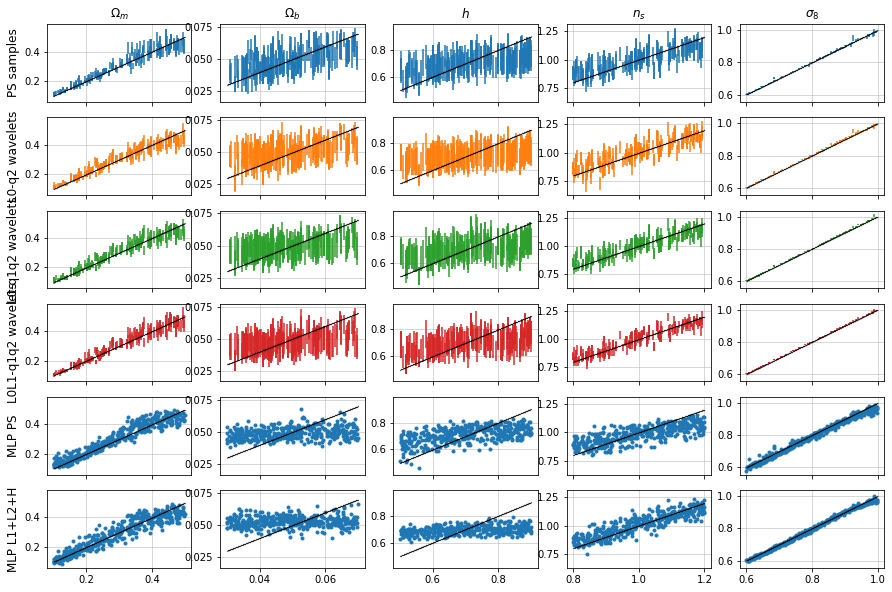

In [219]:
fig, ax = plt.subplots(6, ndim, figsize=(15, 10), sharex='col', sharey='col')

xx = []
nsamples = 1000
lbls = ['PS samples', 'L0-q2\nwavelets', 'L0-q1q2\nwavelets', 'L0L1-q1q2\nwavelets', 'MLP PS', 'MLP L1+L2+H']
for i in range(200):
    
    ii = np.random.randint(0, params_test.shape[0])
    spk = posterior.sample((nsamples,), x=torch.from_numpy(pk_test[ii].astype('float32')), show_progress_bars=False)
    sl0q2 = posterior_l0q2.sample((nsamples,), x=torch.from_numpy(w_l0q2_test[ii].astype('float32')), show_progress_bars=False)
    sl0q1q2 = posterior_l0q1q2.sample((nsamples,), x=torch.from_numpy(w_l0q1q2_test[ii].astype('float32')), show_progress_bars=False)
    sl0l1q1q2 = posterior_l0l1q1q2.sample((nsamples,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')), show_progress_bars=False)
    x = params_test[ii]

    allsamples = [spk, sl0q2, sl0q1q2, sl0l1q1q2]

#     ii = np.random.randint(0, params_test.shape[0])
#     posterior_samples = posterior.sample((nsamples,), x=torch.from_numpy(pk_test[ii].astype('float32')), show_progress_bars=False)
#     posterior_l2_samples = posterior_l2.sample((nsamples,), x=torch.from_numpy(w_l2_test[ii].astype('float32')), show_progress_bars=False)
#     posterior_l1l2_samples = posterior_l1l2.sample((nsamples,), x=torch.from_numpy(w_l1l2_test[ii].astype('float32')), show_progress_bars=False)
#     posterior_l1l2h1_samples = posterior_l1l2h1.sample((nsamples,), x=torch.from_numpy(w_l1l2h1_test[ii].astype('float32')), show_progress_bars=False)
#     x = params_test[ii]

#     allsamples = [posterior_samples, posterior_l2_samples, posterior_l1l2_samples, posterior_l1l2h1_samples]
    xx.append(x)
    for j in range(ndim):
        for iss in range(4):
            ax[iss, j].errorbar(x[j], allsamples[iss][:, j].mean(axis=0), allsamples[iss][:, j].std(axis=0), color='C%d'%iss)

for j in range(ndim):
#     ax[-1].plot(params_train[:, i], nnpred_train[:, i], 'C0.')
    ax[4, j].plot(params_test[:, j], nnpred[:, j], 'C0.')
    ax[5, j].plot(params_test[:, j], nnpred_wl1l2h1[:, j], 'C0.')
    for iss in range(ax.shape[0]):
        if j == 0 : ax[iss, 0].set_ylabel(lbls[iss], fontsize=12)
        ax[iss, j].plot(params_train[:, j], params_train[:, j], 'k.', ms=0.1, lw=0.5)
        ax[iss, j].grid(which='both', lw=0.5)
    ax[0, j].set_title(cosmonames[j], fontsize=12)


In [312]:
ranks = []
means, stds = [], []
for ii in range(pk_test.shape[0]):
# for ii in range(100):
    if ii%20 == 0: print(ii)
    posterior_samples = posterior_l0l1q1q2.sample((2000,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')), show_progress_bars=False).detach().numpy()
    means.append(posterior_samples.mean(axis=0))
    stds.append(posterior_samples.std(axis=0))
    order = np.argsort(posterior_samples, 0)
    sorted = np.array([posterior_samples[:, i][order[:, i]] for i in range(ndim)])
    tmp = []
    for i in range(5):
        try: tmp.append(np.where(sorted[i] > params_test[ii, i])[0][0])
        except Exception as e: 
            print(e)
            tmp.append(np.NaN)
    if np.isnan(tmp).sum(): continue
    else: ranks.append(tmp)

ranks = np.array(ranks)
means = np.array(means)
stds = np.array(stds)    

0
20
40
60
80
100
120
140
160
180
200
index 0 is out of bounds for axis 0 with size 0
220
240
260
280
300
320
340
360
380


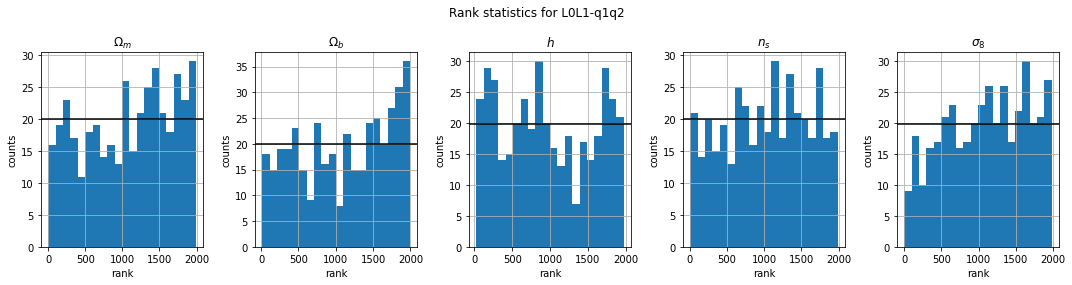

In [313]:
plt.figure(figsize=(15, 4))
nbins = 20 
for i in range(5):
#     plt.hist(np.array(ranks)[:, i], bins=10, histtype='step', lw=2)
    plt.subplot(151 + i)
    plt.hist(ranks[:, i], bins=nbins)
    plt.axhline(ranks.shape[0]/nbins, color='k')
    plt.title(cosmonames[i])
    plt.xlabel('rank')
    plt.ylabel('counts')
    plt.grid()
plt.tight_layout()
plt.suptitle('Rank statistics for L0L1-q1q2')
plt.tight_layout()
plt.show()


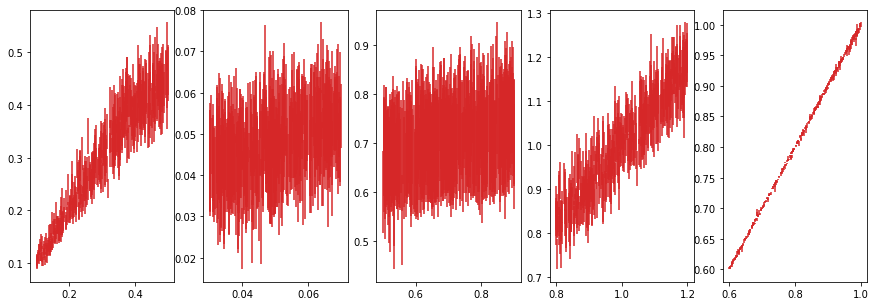

In [314]:
fig, ax = plt.subplots(1, ndim, figsize=(15, 5), sharex='col', sharey='col')

lbls = ['PS samples', 'L0-q2\nwavelets', 'L0-q1q2\nwavelets', 'L0L1-q1q2\nwavelets', 'MLP PS', 'MLP L1+L2+H']

for ii in range(means.shape[0]):
    for j in range(ndim):
        ax[j].errorbar(params_test[ii,j], means[ii,j], stds[ii,j],  color='C%d'%iss)

# for j in range(ndim):
# #     ax[-1].plot(params_train[:, i], nnpred_train[:, i], 'C0.')
#     ax[4, j].plot(params_test[:, j], nnpred[:, j], 'C0.')
#     ax[5, j].plot(params_test[:, j], nnpred_wl1l2h1[:, j], 'C0.')
#     for iss in range(ax.shape[0]):
#         if j == 0 : ax[iss, 0].set_ylabel(lbls[iss], fontsize=12)
#         ax[iss, j].plot(params_train[:, j], params_train[:, j], 'k.', ms=0.1, lw=0.5)
#         ax[iss, j].grid(which='both', lw=0.5)
#     ax[0, j].set_title(cosmonames[j], fontsize=12)


## Do with reduced dimensions

In [340]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=50, num_transforms=5)
inference_nnl0l1q1q2 = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference_nnl0l1q1q2.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(nnpred_wl0l1q1q2_train.astype('float32')))

density_estimator_nnl0l1q1q2 = inference_nnl0l1q1q2.train(show_train_summary=True)
posterior_nnl0l1q1q2 = inference_nnl0l1q1q2.build_posterior(density_estimator_nnl0l1q1q2)

 Neural network successfully converged after 127 epochs.al network. Epochs trained: 6Training neural network. Epochs trained: 14
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 127
        Best validation performance: 14.4336
        -------------------------
        


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]


True values for simulation 299 :  [0.3731  0.05809 0.7835  0.9311  0.7583 ] 

PS samples tensor([0.0302, 0.0079, 0.0861, 0.0740, 0.0014])
L0q2 wavelets tensor([0.0348, 0.0096, 0.0951, 0.0605, 0.0015])
L0q1q2 wavelets tensor([0.0414, 0.0103, 0.0912, 0.0561, 0.0010])
L0L1q1q2 wavelets tensor([0.0354, 0.0099, 0.0988, 0.0476, 0.0011])
NN pred tensor([0.0385, 0.0100, 0.0930, 0.0417, 0.0023])


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


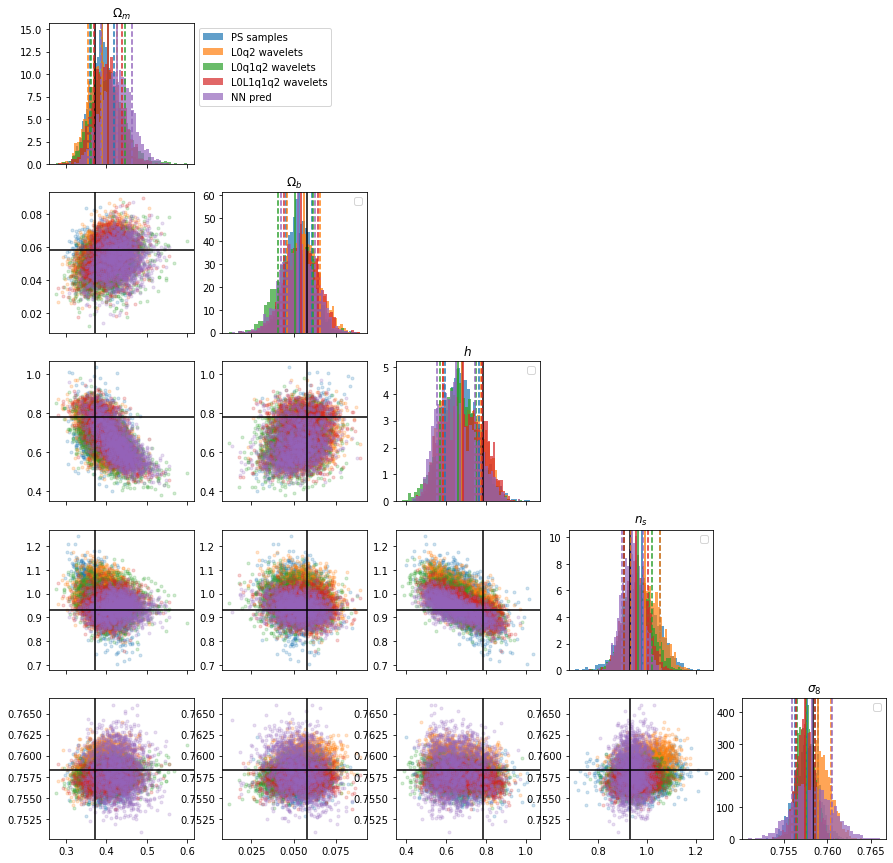

In [342]:
ii = np.random.randint(0, test.size, 1)[0]
posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_test[ii].astype('float32')))
posterior_l0q2_samples = posterior_l0q2.sample((2000,), x=torch.from_numpy(w_l0q2_test[ii].astype('float32')))
posterior_l0q1q2_samples = posterior_l0q1q2.sample((2000,), x=torch.from_numpy(w_l0q1q2_test[ii].astype('float32')))
posterior_l0l1q1q2_samples = posterior_l0l1q1q2.sample((2000,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')))
posterior_nnl0l1q1q2_samples = posterior_nnl0l1q1q2.sample((2000,), x=torch.from_numpy(nnpred_wl0l1q1q2[ii].astype('float32')))
print( '\nTrue values for simulation %d : '%ii, params_test[ii], '\n')


lbls = ['PS samples', 'L0q2 wavelets', 'L0q1q2 wavelets', 'L0L1q1q2 wavelets', 'NN pred']
allsamples = [posterior_samples, posterior_l0q2_samples, posterior_l0q1q2_samples, posterior_l0l1q1q2_samples, posterior_nnl0l1q1q2_samples]
for iss, samples in enumerate(allsamples):
    print(lbls[iss], samples.std(0))

    
###########    
toplot = [0, 1, 2, 3, 4]
lbls = [lbls[i] for i in toplot]
allsamples = [allsamples[i] for i in toplot]

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
           
    
    axar[i, i].axvline(params_test[ii][i], color='k')
    for iss, samples in enumerate(allsamples):        
        cc ='C%d'%iss
        if i == 0: lbl = lbls[iss]
        else: lbl = None
        axar[i, i].hist(np.array(samples[:, i]), density=True, bins=40, label=lbl, color=cc, alpha=0.7);
        axar[i, i].axvline(samples[:, i].mean(), color=cc);
        axar[i, i].axvline(samples[:, i].mean()+samples[:, i].std(), color=cc, ls="--");
        axar[i, i].axvline(samples[:, i].mean()-samples[:, i].std(), color=cc, ls="--");

        for j in range(0, i):
            axar[i, j].plot(samples[:, j], samples[:, i], '.', color=cc, alpha=0.2)

    
    for j in range(0, i):
        axar[i, j].axhline(params_test[ii][i], color='k')
        axar[i, j].axvline(params_test[ii][j], color='k')

    
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])
    axar[i, i].legend(bbox_to_anchor=(1, 1))


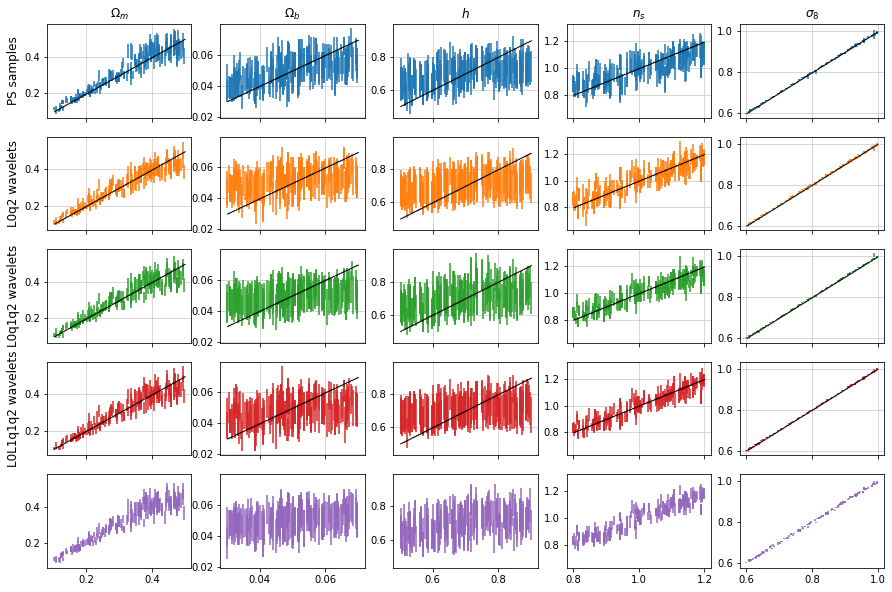

In [344]:
fig, ax = plt.subplots(5, ndim, figsize=(15, 10), sharex='col', sharey='col')

xx = []
nsamples = 1000
for i in range(200):
    
    ii = np.random.randint(0, params_test.shape[0])
    spk = posterior.sample((nsamples,), x=torch.from_numpy(pk_test[ii].astype('float32')), show_progress_bars=False)
    sl0q2 = posterior_l0q2.sample((nsamples,), x=torch.from_numpy(w_l0q2_test[ii].astype('float32')), show_progress_bars=False)
    sl0q1q2 = posterior_l0q1q2.sample((nsamples,), x=torch.from_numpy(w_l0q1q2_test[ii].astype('float32')), show_progress_bars=False)
    sl0l1q1q2 = posterior_l0l1q1q2.sample((nsamples,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')), show_progress_bars=False)
    snnl0l1q1q2 = posterior_nnl0l1q1q2.sample((nsamples,), x=torch.from_numpy(nnpred_wl0l1q1q2[ii].astype('float32')), show_progress_bars=False)
    x = params_test[ii]

    allsamples = [spk, sl0q2, sl0q1q2, sl0l1q1q2, snnl0l1q1q2]
#     allsamples = [sl0l1q1q2]
    xx.append(x)
    for j in range(ndim):
        for iss in range(len(allsamples)):
            ax[iss, j].errorbar(x[j], allsamples[iss][:, j].mean(axis=0), allsamples[iss][:, j].std(axis=0), color='C%d'%iss)

for j in range(ndim):
    for iss in range(ax.shape[0]):
        if j == 0 : ax[iss, 0].set_ylabel(lbls[iss], fontsize=12)
        ax[iss, j].plot(params_train[:, j], params_train[:, j], 'k.', ms=0.1, lw=0.5)
        ax[iss, j].grid(which='both', lw=0.5)
    ax[0, j].set_title(cosmonames[j], fontsize=12)


## With embedding nets

In [413]:
model_embed = nn.Sequential(
    nn.Linear(w_l0l1q1q2_test.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 5)
)

density_estimator_build_fun = posterior_nn(model='maf', hidden_features=50, num_transforms=5, embedding_net=model_embed)
inference_embl0l1q1q2 = SNPE(prior=prior, density_estimator=density_estimator_build_fun)
inference_embl0l1q1q2.append_simulations(
    torch.from_numpy(params_train.astype('float32')), 
    torch.from_numpy(w_l0l1q1q2_train.astype('float32')))

density_estimator_embl0l1q1q2 = inference_embl0l1q1q2.train(show_train_summary=True)
posterior_embl0l1q1q2 = inference_embl0l1q1q2.build_posterior(density_estimator_embl0l1q1q2)

 Neural network successfully converged after 156 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 156
        Best validation performance: 13.5617
        -------------------------
        


Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]


True values for simulation 4 :  [0.2025  0.06355 0.6215  1.1753  0.8689 ] 

PS samples tensor([0.0127, 0.0071, 0.0877, 0.0537, 0.0024])
L0q2 wavelets tensor([0.0150, 0.0076, 0.1039, 0.0483, 0.0027])
L0q1q2 wavelets tensor([0.0164, 0.0076, 0.1001, 0.0407, 0.0019])
L0L1q1q2 wavelets tensor([0.0171, 0.0088, 0.1099, 0.0279, 0.0023])
Embed pred tensor([0.0451, 0.0110, 0.1136, 0.1022, 0.0023])


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


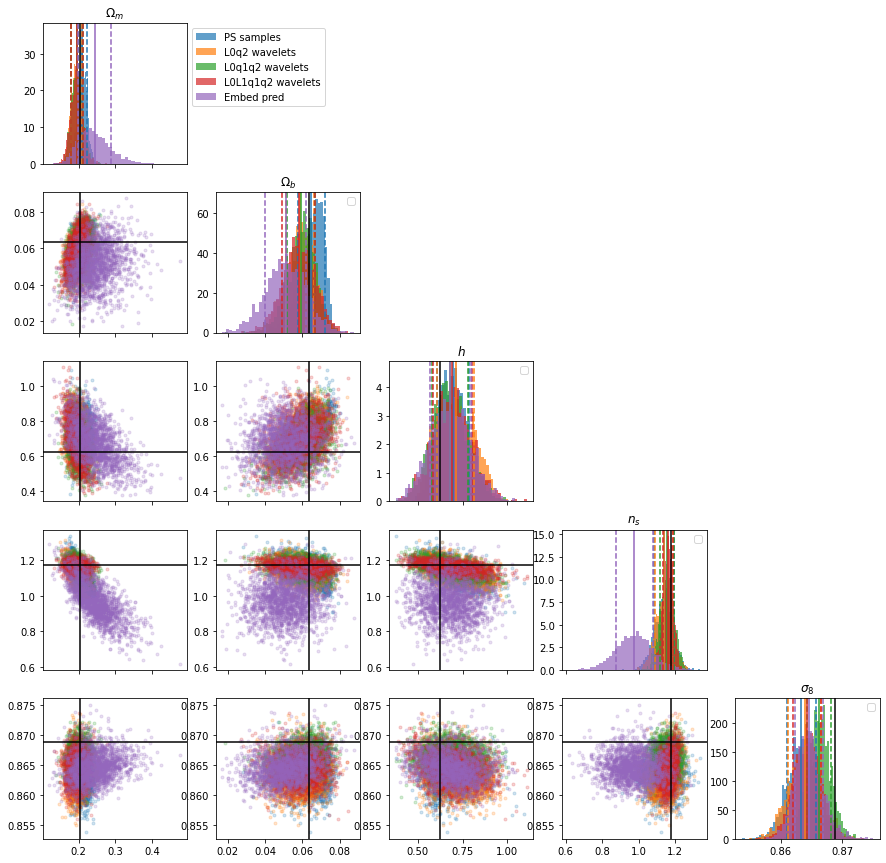

In [423]:
ii = np.random.randint(0, test.size, 1)[0]
posterior_samples = posterior.sample((2000,), x=torch.from_numpy(pk_test[ii].astype('float32')))
posterior_l0q2_samples = posterior_l0q2.sample((2000,), x=torch.from_numpy(w_l0q2_test[ii].astype('float32')))
posterior_l0q1q2_samples = posterior_l0q1q2.sample((2000,), x=torch.from_numpy(w_l0q1q2_test[ii].astype('float32')))
posterior_l0l1q1q2_samples = posterior_l0l1q1q2.sample((2000,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')))
posterior_nnl0l1q1q2_samples = posterior_nnl0l1q1q2.sample((2000,), x=torch.from_numpy(nnpred_wl0l1q1q2[ii].astype('float32')))
posterior_embl0l1q1q2_samples = posterior_embl0l1q1q2.sample((2000,), x=torch.from_numpy(w_l0l1q1q2_test[ii].astype('float32')))
print( '\nTrue values for simulation %d : '%ii, params_test[ii], '\n')


lbls = ['PS samples', 'L0q2 wavelets', 'L0q1q2 wavelets', 'L0L1q1q2 wavelets', 'Embed pred']
allsamples = [posterior_samples, posterior_l0q2_samples, posterior_l0q1q2_samples, posterior_l0l1q1q2_samples, posterior_embl0l1q1q2_samples]
for iss, samples in enumerate(allsamples):
    print(lbls[iss], samples.std(0))

    
###########    
toplot = [0, 1, 2, 3, 4]
lbls = [lbls[i] for i in toplot]
allsamples = [allsamples[i] for i in toplot]

fig, axar = plt.subplots(ndim, ndim, figsize=(3*ndim, 3*ndim), sharex='col')
for i in range(ndim):
           
    
    axar[i, i].axvline(params_test[ii][i], color='k')
    for iss, samples in enumerate(allsamples):        
        cc ='C%d'%iss
        if i == 0: lbl = lbls[iss]
        else: lbl = None
        axar[i, i].hist(np.array(samples[:, i]), density=True, bins=40, label=lbl, color=cc, alpha=0.7);
        axar[i, i].axvline(samples[:, i].mean(), color=cc);
        axar[i, i].axvline(samples[:, i].mean()+samples[:, i].std(), color=cc, ls="--");
        axar[i, i].axvline(samples[:, i].mean()-samples[:, i].std(), color=cc, ls="--");

        for j in range(0, i):
            axar[i, j].plot(samples[:, j], samples[:, i], '.', color=cc, alpha=0.2)

    
    for j in range(0, i):
        axar[i, j].axhline(params_test[ii][i], color='k')
        axar[i, j].axvline(params_test[ii][j], color='k')

    
    for j in range(i+1, ndim):
        axar[i, j].set_axis_off()
for i in range(ndim): 
    axar[i, i].set_title(cosmonames[i])
    axar[i, i].legend(bbox_to_anchor=(1, 1))


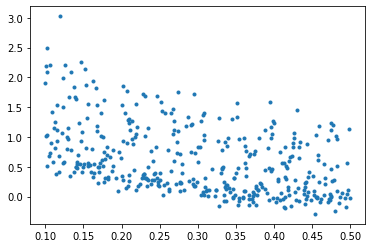

In [420]:
plt.plot(params_test[:, 0], model_embed(torch.tensor(w_l0l1q1q2_test))[:, 0].detach().numpy(), '.')

# Test PM

In [306]:
# field = np.load('../scripts/field0.npy')
field = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0001/field.npy')
print(field.mean())
field /= field.mean()
field -=1 

63.99999999999994


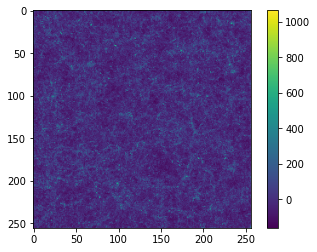

In [307]:
plt.imshow(field.sum(axis=0))
plt.colorbar()

In [202]:
sys.path.append('../../galference/utils/')
import tools

In [243]:
! module load gcc

In [245]:
# from pmesh import ParticleMesh as pmnew

In [289]:
bs, nc = 1000, 256

def cic_compensation(kvec, bs=bs, nc=nc):
  """
  Computes cic compensation kernel.
  Adapted from https://github.com/bccp/nbodykit/blob/a387cf429d8cb4a07bb19e3b4325ffdf279a131e/nbodykit/source/mesh/catalog.py#L499
  Itself based on equation 18 (with p=2) of
        `Jing et al 2005 <https://arxiv.org/abs/astro-ph/0409240>`_
  Args:
    kvec: array of k values in Fourier space  
  Returns:
    v: array of kernel
  """
#   kwts = [np.sinc(kvec[i] / (2 * np.pi)) for i in range(3)]
  kwts = [np.sinc(kvec[i] * bs / (2 * np.pi * nc)) for i in range(3)]
  wts = (kwts[0] * kwts[1] * kwts[2])**(-2)
  return wts


kvec = tools.fftk([field.shape[0]]*3, 1000)
cic_compensation(kvec);

field2 = np.fft.irfftn(np.fft.rfftn(field.copy())*cic_compensation(kvec))
# def decic(pm, n=2):
#     def tf(k):
#         kny = [np.sinc(k[i]*pm.BoxSize[i]/(2*np.pi*pm.Nmesh[i])) for i in range(3)]
#         wts = (kny[0]*kny[1]*kny[2])**(-1*n)
#         return wts

#     if pm.dtype == 'complex128' or pm.dtype == 'complex64':
#         toret = pm.apply(lambda k, v: tf(k)*v).c2r()
#     elif pm.dtype == 'float32' or pm.dtype == 'float64':
#         toret = pm.r2c().apply(lambda k, v: tf(k)*v).c2r()
#     return toret


# field



In [296]:
np.stack([k2, p2]).T.shape

(256, 2)

In [308]:
k2, p = tools.power(field.copy(), boxsize=1000)
k2, p2 = tools.power(field2.copy(), boxsize=1000)


Add 1 to get nonzero mean of 7.495e-16
Add 1 to get nonzero mean of 1.570e-16


In [309]:
kt, pt = np.loadtxt('/mnt/ceph/users/fvillaescusa/Quijote/Pk/matter/latin_hypercube_HR/1/Pk_m_z=0.txt').T
kt2, pt2 = np.loadtxt('/mnt/ceph/users/fvillaescusa/Quijote/Pk/matter/latin_hypercube/0/Pk_m_z=0.txt').T

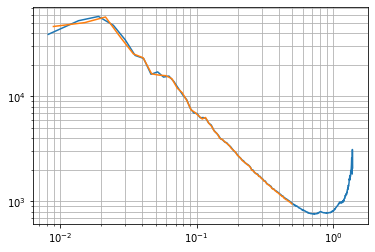

In [311]:
plt.plot(k2, p)
# plt.plot(k2, p2)
plt.plot(k, pk[1])
# plt.plot(kt, pt, '--')
# plt.plot(kt2, pt2, ':')
plt.loglog()
plt.grid(which='both')

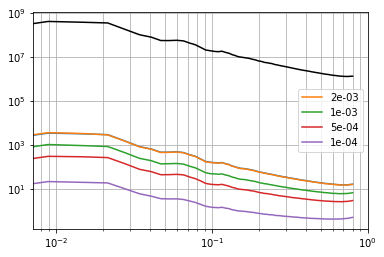

In [531]:
k, ph = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power.npy').T
plt.plot(k, ph, 'k')
k, ph = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/FoF/N0256/0000/power.npy').T
plt.plot(k, ph)
for numd in [2e-3, 1e-3, 5e-4, 1e-4]:
    k, ph = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/FoF/N0256/0000/power_n%0.0e.npy'%numd).T
    plt.plot(k, ph, label='%0.0e'%numd)
plt.loglog()
plt.legend()
plt.grid(which='both')

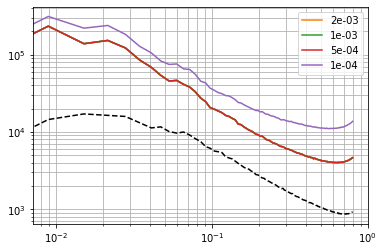

In [544]:
k, ph = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_nwLH/matter/N0256/0010/power.npy').T
plt.plot(k, ph, 'k--')
# k, ph = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_nwLH/matter/N0256/1000/power.npy').T
# plt.plot(k, ph, 'k--')
k, ph = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_nwLH/FoF/N0256/0000/power.npy').T
plt.plot(k, ph)
for numd in [2e-3, 1e-3, 5e-4, 1e-4]:
    k, ph = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_nwLH/FoF/N0256/0000/power_n%0.0e.npy'%numd).T
    plt.plot(k, ph, label='%0.0e'%numd)
plt.loglog()
plt.legend()
plt.grid(which='both')

In [564]:
from matplotlib.colors import LogNorm

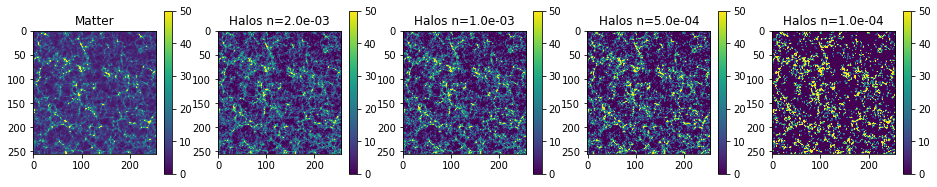

In [622]:
fig, ax = plt.subplots(1, 5, figsize=(16, 3))

ii = 10
vmin, vmax = 0, 50

i = 0
f = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter//N0256/0010/field.npy')
im = ax[i].imshow(f[:ii,...].sum(axis=0)/f.mean(), vmin=vmin, vmax=vmax)
ax[i].set_title('Matter')
plt.colorbar(im, ax=ax[i])

numd = [None, 2e-3, 1e-3, 5e-4, 1e-4]
for i in range(1, 5):
    f = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/FoF//N0256/0010/field_n%0.0e.npy'%numd[i])
    im = ax[i].imshow(f[:ii,...].sum(axis=0)/f.mean(), vmin=vmin, vmax=vmax)
    ax[i].set_title("Halos n=%0.1e"%numd[i])
    plt.colorbar(im, ax=ax[i])
    

In [626]:
f = np.load('/mnt/ceph/users/cmodi/simbig/mesh/LH1540.z0p0.zheng07.2.npy')

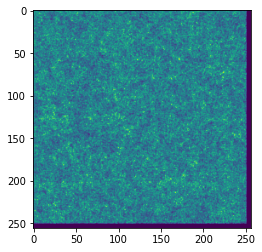

In [630]:
plt.imshow(f.sum(axis=0))

In [634]:
# !module load gcc openmpi

/tmp/ipykernel_2328407/1305181664.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k, p/p0, 'C%d'%j)
/tmp/ipykernel_2328407/1305181664.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k, p/p0, 'C%d'%j)
/tmp/ipykernel_2328407/1305181664.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k, p/p0, 'C%d'%j)
/tmp/ipykernel_2328407/1305181664.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k,p/p0, 'C%d--'%j)
/tmp/ipykernel_2328407/1305181664.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k,p/p0, 'C%d--'%j)
/tmp/ipykernel_2328407/1305181664.py:9: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(k,p/p0, 'C%d--'%j)


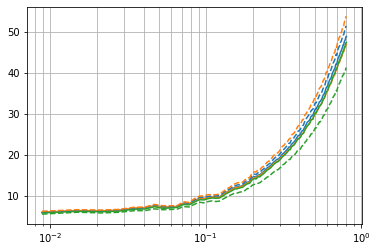

In [662]:
k, p0 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power.npy').T
for j in range(3):
#     k, p = np.load('/mnt/ceph/users/cmodi/simbig/mesh/N0256/0000/power_zheng07.%d.npy'%j).T
    k, p = np.load('/mnt/ceph/users/cmodi/simbig/mesh/N0256/0000/compensated_power_zheng07.%d.npy'%j).T
    plt.plot(k, p/p0, 'C%d'%j)
for j in range(3):
#     k, p = np.load('/mnt/ceph/users/cmodi/simbig/mesh/N0256/0000/power_zheng07_ab.%d.npy'%j).T
    k, p = np.load('/mnt/ceph/users/cmodi/simbig/mesh/N0256/0000/compensated_power_zheng07_ab.%d.npy'%j).T
    plt.plot(k,p/p0, 'C%d--'%j)
# plt.loglog()
plt.semilogx()
plt.grid(which='both')

[]

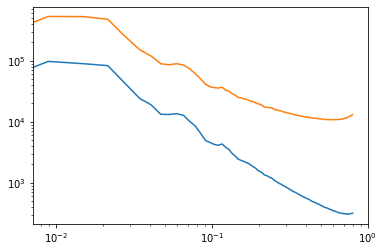

In [663]:
plt.plot(k, p0)
plt.plot(k, p)
plt.loglog()

In [664]:
p/p0

/tmp/ipykernel_2328407/1739932586.py:1: RuntimeWarning: invalid value encountered in true_divide
  p/p0


array([        nan,  5.46117219,  5.9216794 ,  5.75202008,  5.91303979,
        6.28315326,  6.32186921,  6.74836542,  6.53342318,  6.5977201 ,
        6.6854768 ,  7.29745749,  7.20309213,  7.86833388,  8.36407123,
        8.21841406,  8.52378738,  8.70464071,  8.53590865,  8.63820065,
        9.1122902 ,  9.54813161,  9.94600728, 10.27931808, 10.59434544,
       10.62075459, 10.86117486, 10.90384684, 11.25955487, 11.68928864,
       11.78494899, 12.45103114, 12.71409788, 12.73202551, 12.98980488,
       13.13546306, 13.51637685, 13.78052252, 14.1430388 , 14.51161013,
       14.63895346, 15.00843852, 15.41262263, 15.70170526, 16.04049684,
       16.21559412, 16.32196976, 16.68387937, 16.9667873 , 17.46400774,
       17.59990055, 17.89411318, 18.25500682, 18.44100669, 18.74997243,
       18.85990148, 19.34158089, 19.61306643, 19.73582412, 20.02325717,
       20.37683937, 20.84278534, 21.03771897, 21.17651847, 21.33640165,
       21.83016361, 22.18334103, 22.22951621, 22.69542553, 23.14

In [669]:
j = 0
for j in range(3):
    print(np.load('/mnt/ceph/users/cmodi/simbig/catalogs/hod.quijote_LH0.z0p0.zheng07_ab.%d.npy'%j, allow_pickle=True))

{'logMmin': 13.283404400940514, 'sigma_logM': 0.47203244934421584, 'logM0': 13.100057187408671, 'logM1': 14.120933029052736, 'alpha': 0.7587023563268451, 'mean_occupation_centrals_assembias_param1': 0.0461692973843989, 'mean_occupation_satellites_assembias_param1': 0.09313010568883545}
{'logMmin': 13.26911214540861, 'sigma_logM': 0.439676747423067, 'logM0': 13.369408367001679, 'logM1': 14.167677805761318, 'alpha': 0.9740878001587038, 'mean_occupation_centrals_assembias_param1': 0.10222612486575872, 'mean_occupation_satellites_assembias_param1': 0.4390587181954727}
{'logMmin': 13.205477518639585, 'sigma_logM': 0.46704675101784027, 'logM0': 13.308652401183563, 'logM1': 14.223475931378301, 'alpha': 0.7561547754380935, 'mean_occupation_centrals_assembias_param1': 0.0990507445424394, 'mean_occupation_satellites_assembias_param1': 0.40037228433776834}


In [671]:
i = 0 
for j in range(3):
    print(np.load('/mnt/ceph/users/cmodi/simbig/catalogs/hod.quijote_LH%d.z0p0.zheng07.%d.npy'%(i, j), allow_pickle=True))

{'logMmin': 13.262553300705385, 'sigma_logM': 0.47203244934421584, 'logM0': 13.100045749926938, 'logM1': 14.090699771789552, 'alpha': 0.7587023563268451}
{'logMmin': 13.21385078921532, 'sigma_logM': 0.4186260211377671, 'logM0': 13.238224290817218, 'logM1': 14.1190302422692, 'alpha': 0.9155266936013428}
{'logMmin': 13.262879177160494, 'sigma_logM': 0.468521950039676, 'logM0': 13.181780899892606, 'logM1': 14.263435230917283, 'alpha': 0.7109550372791704}


In [672]:
i = 10
for j in range(3):
    print(np.load('/mnt/ceph/users/cmodi/simbig/catalogs/hod.quijote_LH%d.z0p0.zheng07.%d.npy'%(i, j), allow_pickle=True))

{'logMmin': 13.341016122350004, 'sigma_logM': 0.45820141799470804, 'logM0': 13.451532793764738, 'logM1': 14.253420333617667, 'alpha': 1.0621569274834597}
{'logMmin': 13.26898203987252, 'sigma_logM': 0.45463468160203735, 'logM0': 13.419441436460815, 'logM1': 14.085715655520245, 'alpha': 0.8961014090479711}
{'logMmin': 13.28986654614688, 'sigma_logM': 0.4015533275550836, 'logM0': 13.337392563278655, 'logM1': 14.130102904696837, 'alpha': 1.0229442115539364}
